In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

2.4.1
TensorFlow version: 2.4.1
Keras version: 2.4.0


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
classes = pd.read_csv("data/Train.csv")

min_width, max_width = max(classes.Width), min(classes.Width)
min_height, max_height = max(classes.Height), min(classes.Height)

print(np.mean([min_width, max_width]))
print(np.mean([min_height, max_height]))

134.0
125.0


In [4]:
classes_no = len(classes.ClassId.unique())
print("There are {} unique classes in the dataset.".format(classes_no))

There are 43 unique classes in the dataset.


#### Load a pre-trained model

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(input_shape=(125, 125, 3), weights='imagenet', include_top=False)

In [ ]:
base_model.summary()

In [7]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Add a dropout layer to avoid overfitting (drop 20%)
# and a logistic layer
predictions = Dense(classes_no, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_crossentropy'])

Load the data and use data augmentation

In [10]:
cwd = os.getcwd()
base_dir = os.path.join(cwd, 'data')
train_path= os.path.join(base_dir, 'Train')
test_path= os.path.join(base_dir, 'Test')

In [11]:
BATCH_SIZE = 20
TARGET_SIZE = (125, 125)

In [12]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                        target_size=TARGET_SIZE, 
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_crossentropy', patience=10)

In [17]:
history = model.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=100,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      validation_freq=10,
      callbacks = [callback],
      verbose=1)

Epoch 1/100
1568/1568 [==============================] - 302s 186ms/step - loss: 2.7449 - accuracy: 0.3817 - categorical_crossentropy: 2.7449s - loss: 2.7709 - accur
Epoch 2/100
1568/1568 [==============================] - 119s 76ms/step - loss: 1.4392 - accuracy: 0.5453 - categorical_crossentropy: 1.4392
Epoch 3/100
1568/1568 [==============================] - 117s 75ms/step - loss: 1.4204 - accuracy: 0.5644 - categorical_crossentropy: 1.4204
Epoch 4/100
1568/1568 [==============================] - 121s 77ms/step - loss: 1.4101 - accuracy: 0.5706 - categorical_crossentropy: 1.4101
Epoch 5/100
1568/1568 [==============================] - 117s 75ms/step - loss: 1.4133 - accuracy: 0.5896 - categorical_crossentropy: 1.4133
Epoch 6/100
1568/1568 [==============================] - 117s 75ms/step - loss: 1.4327 - accuracy: 0.5856 - categorical_crossentropy: 1.4327
Epoch 7/100
1568/1568 [==============================] - 116s 74ms/step - loss: 1.4269 - accuracy: 0.5898 - categorical_crossentr

In [18]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [19]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = model.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=50,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/50
1568/1568 [==============================] - 275s 169ms/step - loss: 2.2354 - accuracy: 0.4884 - val_loss: 1.4462 - val_accuracy: 0.5864
Epoch 2/50
1568/1568 [==============================] - 202s 129ms/step - loss: 1.1978 - accuracy: 0.6182 - val_loss: 1.2749 - val_accuracy: 0.6356
Epoch 3/50
1568/1568 [==============================] - 137s 87ms/step - loss: 1.0220 - accuracy: 0.6677 - val_loss: 1.2177 - val_accuracy: 0.6508
Epoch 4/50
1568/1568 [==============================] - 138s 88ms/step - loss: 0.9163 - accuracy: 0.7018 - val_loss: 1.1065 - val_accuracy: 0.6758
Epoch 5/50
1568/1568 [==============================] - 139s 89ms/step - loss: 0.8035 - accuracy: 0.7348 - val_loss: 1.0945 - val_accuracy: 0.6906
Epoch 6/50
1568/1568 [==============================] - 142s 91ms/step - loss: 0.7549 - accuracy: 0.7470 - val_loss: 1.0329 - val_accuracy: 0.6954
Epoch 7/50
1568/1568 [==============================] - 142s 90ms/step - loss: 0.7149 - accuracy: 0.7612 - val_loss:

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

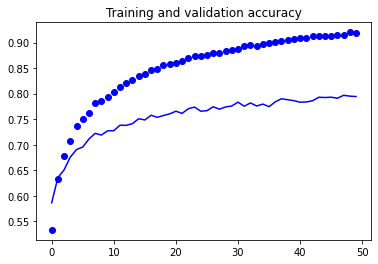

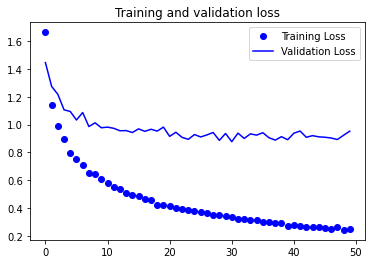

In [22]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
model.save('trained_model/my_model_50_epochs') 

INFO:tensorflow:Assets written to: trained_model/my_model_50_epochs\assets


### Load saved model

In [13]:
model_path = os.path.join(cwd, "trained_model/my_model_50_epochs")
model = tf.keras.models.load_model(model_path)

In [14]:
results = model.evaluate(test_data, batch_size=200)

632/632 [==============================] - 94s 135ms/step - loss: 0.8152 - accuracy: 0.8101


In [ ]:
import glob
test_image_path = glob.glob('Data/Test/*.*')

In [ ]:
labels = np.expand_dims(test_labels, axis=1)

In [ ]:
data = []

for img in test_image_path[0:1000]:   
    img = tf.keras.preprocessing.image.load_img(img, target_size=(125, 125))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x/255
    data.append(x)

In [24]:
results = model.evaluate(test_data, batch_size=100)

632/632 [==============================] - 73s 116ms/step - loss: 0.8152 - accuracy: 0.8101


In [29]:
predictions = np.argmax(model.predict(test_data, steps=1), axis=1)

3 2


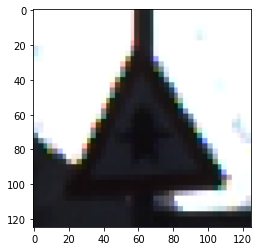

5 34


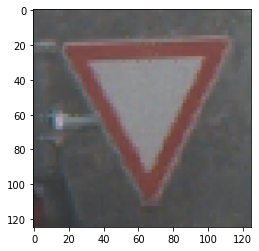

10 6


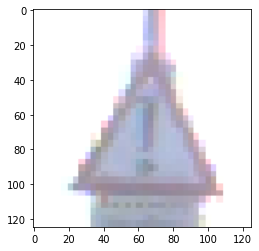

5 5


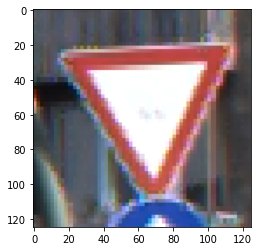

42 4


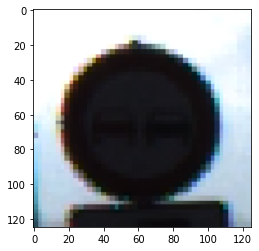

5 2


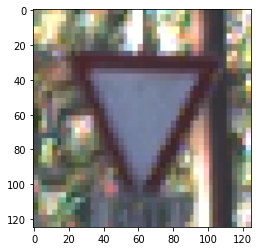

5 17


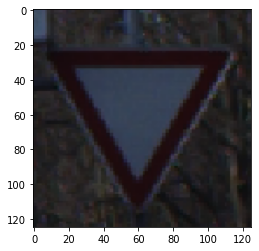

10 5


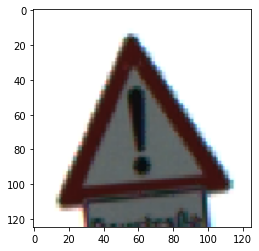

37 9


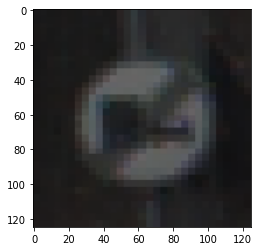

11 34


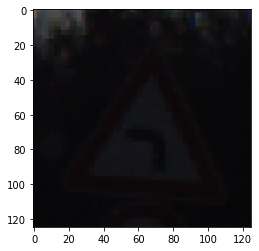

27 18


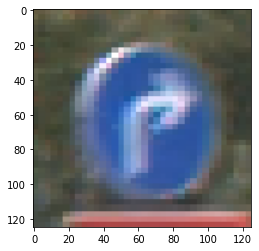

13 35


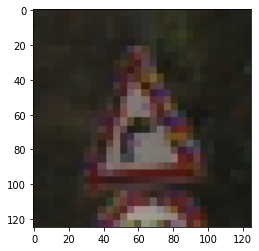

42 38


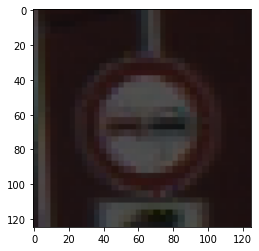

41 18


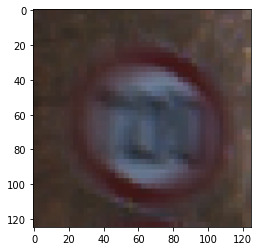

22 34


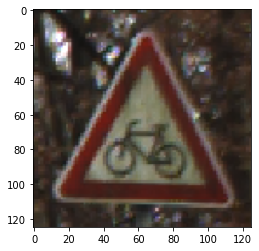

4 7


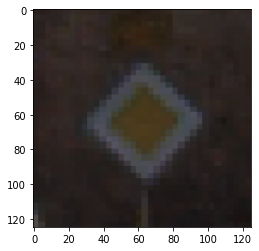

24 34


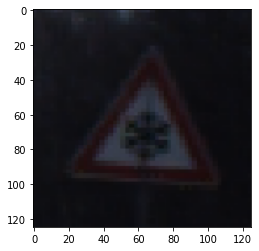

28 29


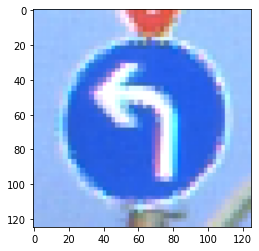

23 42


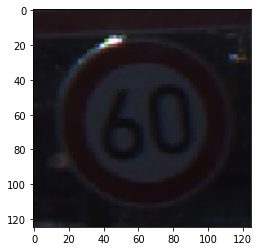

38 32


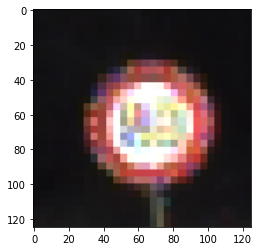

In [30]:
test_labels_com=[]

for i in range(len(predictions)):
    img, label = test_data.next()
    l = np.argmax(label[0])
    print(l, predictions[i])
    test_labels_com.append(l)
    plt.imshow(img[0])
    plt.show()

In [ ]:
number_of_examples

In [ ]:
import math

number_of_examples = len(test_data.filenames)
#number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 1)) 

test_labels_com = []

for i in range(0, int(number_of_examples)):
    test_labels_com.append(np.argmax(test_data[i][1]))

In [ ]:
test_labels_com

In [ ]:
tf.stack([np.argmax(predictions, axis=1), test_labels_com], axis=1)

LeNEt 5 model    

In [26]:
def leNet():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(125,125,1)))
    model.add(layers.AveragePooling2D())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(layers.AveragePooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(units=120, activation='relu'))

    model.add(layers.Dense(units=84, activation='relu'))

    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(units=43, activation = 'softmax'))
    
    return model

In [27]:
from tensorflow.keras.optimizers import Adam

lenet = leNet()
lenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
BATCH_SIZE = 50

In [30]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=30,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/30
627/627 [==============================] - 85s 135ms/step - loss: 2.9850 - accuracy: 0.1795 - val_loss: 2.5969 - val_accuracy: 0.3356
Epoch 2/30
627/627 [==============================] - 59s 93ms/step - loss: 2.8735 - accuracy: 0.1996 - val_loss: 2.4977 - val_accuracy: 0.3683
Epoch 3/30
627/627 [==============================] - 52s 84ms/step - loss: 2.8027 - accuracy: 0.2147 - val_loss: 2.3785 - val_accuracy: 0.3865
Epoch 4/30
627/627 [==============================] - 49s 77ms/step - loss: 2.7345 - accuracy: 0.2266 - val_loss: 2.2652 - val_accuracy: 0.4356
Epoch 5/30
627/627 [==============================] - 47s 75ms/step - loss: 2.6740 - accuracy: 0.2380 - val_loss: 2.2064 - val_accuracy: 0.4538
Epoch 6/30
627/627 [==============================] - 45s 72ms/step - loss: 2.6265 - accuracy: 0.2483 - val_loss: 2.1681 - val_accuracy: 0.4647
Epoch 7/30
627/627 [==============================] - 45s 71ms/step - loss: 2.5826 - accuracy: 0.2598 - val_loss: 2.1480 - val_accuracy

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

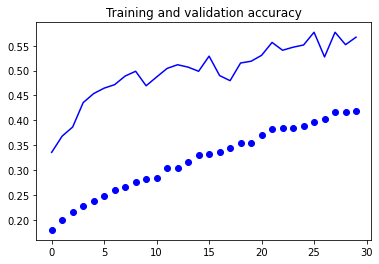

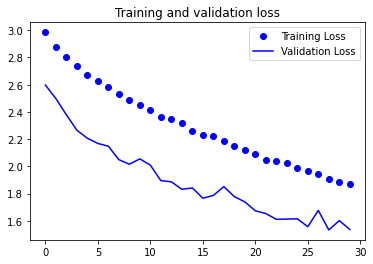

In [32]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=60,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/60
627/627 [==============================] - 42s 67ms/step - loss: 1.8630 - accuracy: 0.4224 - val_loss: 1.5581 - val_accuracy: 0.5519
Epoch 2/60
627/627 [==============================] - 44s 70ms/step - loss: 1.8526 - accuracy: 0.4190 - val_loss: 1.5098 - val_accuracy: 0.5708
Epoch 3/60
627/627 [==============================] - 44s 71ms/step - loss: 1.8131 - accuracy: 0.4352 - val_loss: 1.4803 - val_accuracy: 0.5837
Epoch 4/60
627/627 [==============================] - 47s 76ms/step - loss: 1.7967 - accuracy: 0.4384 - val_loss: 1.4779 - val_accuracy: 0.5747
Epoch 5/60
627/627 [==============================] - 50s 80ms/step - loss: 1.7687 - accuracy: 0.4497 - val_loss: 1.4744 - val_accuracy: 0.5843
Epoch 6/60
627/627 [==============================] - 47s 75ms/step - loss: 1.7511 - accuracy: 0.4522 - val_loss: 1.4295 - val_accuracy: 0.6042
Epoch 7/60
627/627 [==============================] - 48s 76ms/step - loss: 1.7400 - accuracy: 0.4538 - val_loss: 1.4361 - val_accuracy:

In [39]:
from tensorflow.keras.optimizers import SGD
lenet.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=50,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/50
627/627 [==============================] - 43s 69ms/step - loss: 1.1959 - accuracy: 0.6053 - val_loss: 1.1317 - val_accuracy: 0.6881
Epoch 2/50
627/627 [==============================] - 45s 72ms/step - loss: 1.1988 - accuracy: 0.5963 - val_loss: 1.0983 - val_accuracy: 0.6929
Epoch 3/50
627/627 [==============================] - 46s 73ms/step - loss: 1.1706 - accuracy: 0.6045 - val_loss: 1.1731 - val_accuracy: 0.6734
Epoch 4/50
627/627 [==============================] - 46s 73ms/step - loss: 1.1664 - accuracy: 0.6053 - val_loss: 1.2538 - val_accuracy: 0.6468
Epoch 5/50
627/627 [==============================] - 45s 72ms/step - loss: 1.1575 - accuracy: 0.6080 - val_loss: 1.1535 - val_accuracy: 0.6795
Epoch 6/50
627/627 [==============================] - 45s 72ms/step - loss: 1.1769 - accuracy: 0.6030 - val_loss: 1.0701 - val_accuracy: 0.6830
Epoch 7/50
627/627 [==============================] - 47s 75ms/step - loss: 1.1728 - accuracy: 0.6089 - val_loss: 1.1977 - val_accuracy:

KeyboardInterrupt: 